<a href="https://colab.research.google.com/github/akaanirban/a-dnn-every-week/blob/main/NLP/SeqTOSeq/Simple_Seq_to_Seq_nmt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### In this example, we look at sequence to sequence text translation (Neural Machine Translation if you are feeling fancy) using a simple encoder decoder approach with the help of LSTM. The results are hilarious and objectively garbage but it gets the point across. We use the small english to bengali translated dataset from Tatoeba. 

In [2]:
!pip install torch torchvision

In [1]:
import torch
import torch.nn as nn
import torch.functional as F
import torchvision

In [2]:
! wget http://www.manythings.org/anki/ben-eng.zip
! unzip ben-eng.zip

--2021-07-30 04:30:13--  http://www.manythings.org/anki/ben-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.92.44, 172.67.186.54, 2606:4700:3033::ac43:ba36, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.92.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134552 (131K) [application/zip]
Saving to: ‘ben-eng.zip’

ben-eng.zip         100%[===================>] 131.40K  --.-KB/s    in 0.1s    

2021-07-30 04:30:14 (1.08 MB/s) - ‘ben-eng.zip’ saved [134552/134552]

Archive:  ben-eng.zip
  inflating: _about.txt              
  inflating: ben.txt                 


In [3]:
! head ben.txt

Go.	যাও।	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5545004 (tanay)
Go.	যান।	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5545005 (tanay)
Go.	যা।	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5545006 (tanay)
Run!	পালাও!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #5548781 (tanay)
Run!	পালান!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #5548783 (tanay)
Who?	কে?	CC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #5548787 (tanay)
Fire!	আগুন!	CC-BY 2.0 (France) Attribution: tatoeba.org #1829639 (Spamster) & #3232240 (tanay)
Help!	বাঁচাও!	CC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #5548780 (tanay)
Help!	বাঁচান!	CC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #5548782 (tanay)
Stop!	থামুন!	CC-BY 2.0 (France) Attribution: tatoeba.org #448320 (CM) & #5545000 (tanay)


In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

In [5]:
# import nltk 
# nltk.download('stopwords')
# STOPWORDS_ENG = nltk.corpus.stopwords.words('english')
# STOPWORDS_BENG = nltk.corpus.stopwords.words('bengali')
PUNCTUATIONS = [ '!', '"', '#', '$', '%', '&', '(', ')', '*', '+', '-', '.', '/',  '\\', ':', ';', '<', '=', '>',
           '?', '@', '[', ']', '^', '_', '`', '{', '|', '}', '\t','\n',"'",",",'~' , '—']
punct_regex_expression = "[!\"#$%&()*+-.\/\\:;<=>?@[\]^_`{|}\\t\\n\',~—]"

In [7]:
lines= pd.read_table('ben.txt', names=['ben', 'eng'])

In [8]:
lines.reset_index(inplace=True)

In [9]:
lines.head()

,index,ben,eng
0,Go.,যাও।,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,যান।,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,যা।,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Run!,পালাও!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
4,Run!,পালান!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [10]:
lines.columns = ["eng", "ben", "info"]
lines.drop(['info'], axis=1, inplace=True)

In [11]:
lines.head()

,eng,ben
0,Go.,যাও।
1,Go.,যান।
2,Go.,যা।
3,Run!,পালাও!
4,Run!,পালান!


In [12]:
# Remove Punctuations
lines = lines[lines.notna()]
transtable = str.maketrans(dict.fromkeys("".join(PUNCTUATIONS), ''))
numbers = str.maketrans(dict.fromkeys("0123456789০১২৩৪৫৬৭৮৯", ""))
lines['eng'] = (lines['eng'].str.lower()
                        .str.translate(transtable)
                        .str.translate(numbers)
                        .str.strip())
lines['ben'] = (lines['ben'].str.lower()
                        .str.translate(transtable)
                        .str.translate(numbers)
                        .str.strip())

In [13]:
# Add start and end tokens to target sequences
lines.ben = lines.ben.apply(lambda x : 'START_ '+ x + ' _END')

In [14]:
lines.sample(10)

,eng,ben
1785,i am years old,START_ আমার বছর বয়স। _END
1253,heres your key,START_ এই নিন আপনার চাবি। _END
3780,would you like to come inside,START_ আপনারা কি ভেতরে আসবেন _END
3755,tom certainly is hypocritical,START_ টম সত্যিই কুটিল। _END
3263,i dont know what you mean,START_ আমি জানিনা আপনি কি বোঝাতে চাইছেন। _END
1269,how old is this,START_ এটার বয়স কত _END
1614,i heard a scream,START_ আমি একটা চিৎকার শুনলাম। _END
1856,they all screamed,START_ তারা সবাই চেঁচালো। _END
4486,tom works very hard but not as hard as mary,START_ টম খুব খাটে কিন্তু মেরির মতো নয়। _END
3428,i thought tom was in danger,START_ আমি ভেবেছিলাম টম বিপদে পরেছে। _END


In [15]:
# english and bengali vocab in the dataset 
eng_words = set([i for j in lines.eng for i in j.split()])
ben_words = set([i for j in lines.ben for i in j.split()])

In [16]:
# max source and target sequence
eng_max = max([len(i.split()) for i in lines.eng])
ben_max = max([len(j.split()) for j in lines.ben])
print(eng_max, ben_max)

19 20


In [17]:
input_words = sorted(list(eng_words))
target_words = sorted(list(ben_words))
num_encoder_tokens = len(eng_words)
num_decoder_tokens = len(ben_words)
num_encoder_tokens, num_decoder_tokens

(1884, 3394)

In [18]:
num_decoder_tokens += 1 # For zero padding
num_decoder_tokens
num_encoder_tokens += 1 # For zero padding
num_encoder_tokens
# https://stackoverflow.com/questions/54176051/invalidargumenterror-indicesi-0-x-is-not-in-0-x-in-keras

1885

In [19]:
# string to index and index to string 
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [20]:
lines = shuffle(lines)
lines.head(10)

,eng,ben
3693,wheres the nearest hospital,START_ কাছাকাছির মধ্যে হাসপাতালটা কোথায় আছে _END
3835,please show me the green shirt,START_ আমাকে একটু সবুজ জামাটা দেখাবেন। _END
3559,we heard tom was in trouble,START_ আমরা শুনলাম টম ঝামেলায় পরেছিল। _END
3287,is there a hospital nearby,START_ কাছাকাছির মধ্যে কোন হাসপাতাল আছে _END
4482,tom is eating breakfast alone in the kitchen,START_ টম রান্নাঘরে একলা প্রাতরাশ করছে। _END
4144,do you want to eat noodles or rice,START_ আপনি কি নুডলস খেতে চান না ভাত খেতে চান ...
3866,we dont have that information,START_ আমাদের কাছে সেই তথ্য নেই। _END
1830,my father is here,START_ আমার বাবা এখানে আছেন। _END
34,really,START_ সত্যি _END
3140,i cant lift my right arm,START_ আমি আমার ডান হাতটা তুলতে পারছি না। _END


In [21]:
# Train - Test Split
X, y = lines.eng, lines.ben
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape

((4173,), (464,))

In [22]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    global eng_max, ben_max, num_decoder_tokens
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, eng_max),dtype='float32')
            decoder_input_data = np.zeros((batch_size, ben_max),dtype='float32')
            decoder_target_data = np.zeros((batch_size, ben_max, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

### Encoder Decoder Model architecture from : 
https://github.com/hlamba28/Word-Level-Eng-Mar-NMT/blob/master/WordLevelEngMarNMT.ipynb

Few enhancements would be :
1. Using a multi layered LSTM
2. Using a bi-directional LSTM
3. Using a different metric than Accuracy

In [23]:
latent_dim = 60

In [24]:
# Encoder Model is a LSTM --> Many to one LSTM and we use the Embedding layer from keras
# model = Sequential()
encoder_inputs = Input(shape=(None,))
encoder_embeddings = Embedding(num_encoder_tokens+1, latent_dim, mask_zero=True)(encoder_inputs)
encoder_lstm1 = LSTM(units=latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm1(encoder_embeddings)
# discard the individual output and only keep the hidden state and the cell state
encoder_states = [state_h, state_c]

In [25]:
# set up the decoder where we feed in the encoder state
decoder_inputs = Input(shape=(None,))
decoder_embedding_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero=True)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

# we need the return sequences and return states. we wil feed in the return sequences output to the model during inference
decoder_lstm = LSTM(units=latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embeddings, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

In [26]:
# The overall model will now turn `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [31]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

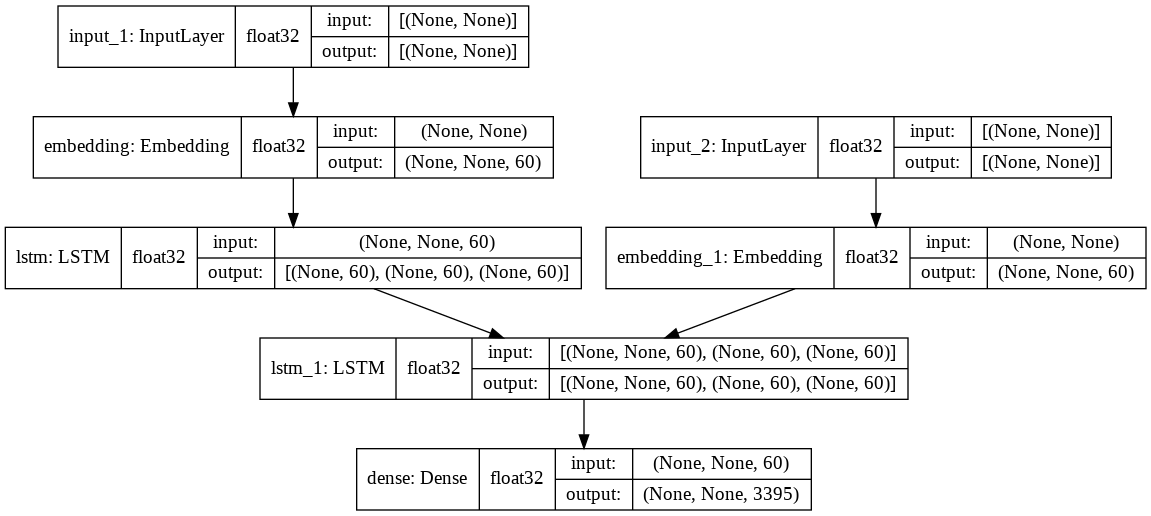

In [32]:
import tensorflow as tf
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [33]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 100
epochs = 40

In [35]:
model.fit(generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    verbose=True,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/40
41/41 [==============================] - 25s 100ms/step - loss: 2.0372 - acc: 0.1633 - val_loss: 1.6329 - val_acc: 0.1859
Epoch 2/40
41/41 [==============================] - 2s 42ms/step - loss: 1.5311 - acc: 0.1879 - val_loss: 1.6085 - val_acc: 0.1859
Epoch 3/40
41/41 [==============================] - 2s 41ms/step - loss: 1.5160 - acc: 0.1875 - val_loss: 1.5782 - val_acc: 0.1859
Epoch 4/40
41/41 [==============================] - 2s 42ms/step - loss: 1.4810 - acc: 0.1867 - val_loss: 1.5440 - val_acc: 0.1859
Epoch 5/40
41/41 [==============================] - 2s 43ms/step - loss: 1.4406 - acc: 0.1879 - val_loss: 1.5200 - val_acc: 0.1952
Epoch 6/40
41/41 [==============================] - 2s 42ms/step - loss: 1.4166 - acc: 0.2076 - val_loss: 1.4924 - val_acc: 0.2207
Epoch 7/40
41/41 [==============================] - 2s 42ms/step - loss: 1.3818 - acc: 0.2238 - val_loss: 1.4747 - val_acc: 0.2268
Epoch 8/40
41/41 [==============================] - 2s 44ms/step - loss: 1.3601 -

In [36]:
model.save_weights('nmt_weights.h5')

In [37]:
model.load_weights('nmt_weights.h5')

In [38]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder Step 
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
dec_emb2= decoder_embedding_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# set the output from prev layer to the inputs of the first layer for decoder sequence
decoder_ops, decoder_H, decoder_C = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states_2 = [decoder_H, decoder_C]
decoder_ops = decoder_dense(decoder_ops) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_ops] + decoder_states_2)

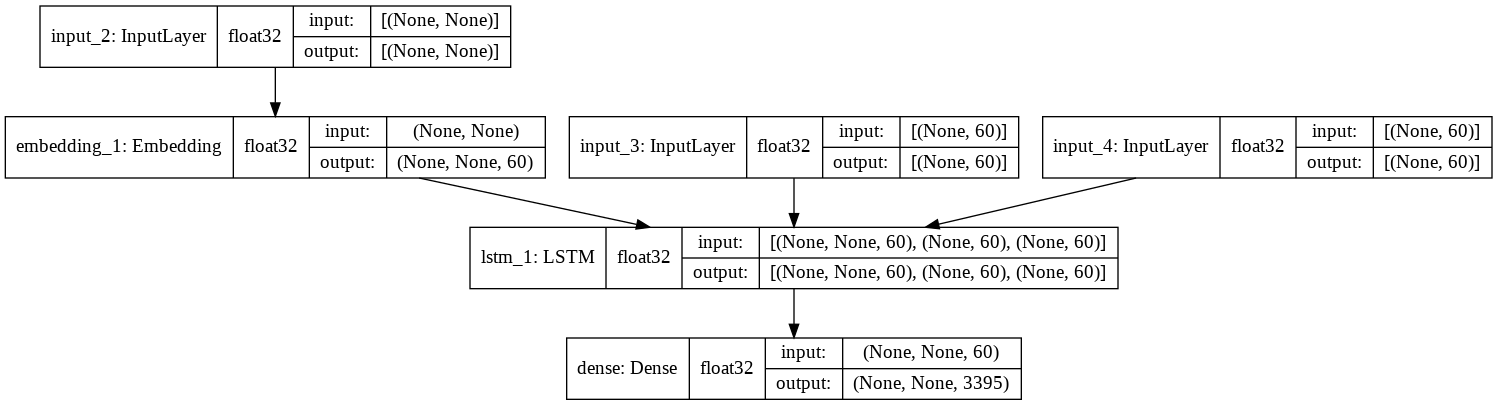

In [39]:
import tensorflow as tf
tf.keras.utils.plot_model(
    decoder_model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

## Inference Setup

In [40]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [41]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [45]:
for i in range(20):
    k+=1
    (input_seq, actual_output), _ = next(train_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('Input English sentence:', X_train[k:k+1].values[0])
    print('Actual Bengali Translation:', y_train[k:k+1].values[0][6:-4])
    print('Predicted Bengali Translation:', decoded_sentence[:-4])
    print("-"*80)

Input English sentence: may i have your phone number
Actual Bengali Translation:  আমি কি আপনার ফোন নাম্বারটি পেতে পারি 
Predicted Bengali Translation:  আমি কি আমার সাথে কথা বলতে পারি 
--------------------------------------------------------------------------------
Input English sentence: can you get a day off
Actual Bengali Translation:  তুমি কে একদিনের ছুটি নিতে পারবে 
Predicted Bengali Translation:  আপনি কি কখনো আছে 
--------------------------------------------------------------------------------
Input English sentence: anything else
Actual Bengali Translation:  আর কিছু 
Predicted Bengali Translation:  আমরা কি আছে 
--------------------------------------------------------------------------------
Input English sentence: they seem american
Actual Bengali Translation:  তাদের দেখে আমেরিকান বলে মনে হচ্ছে। 
Predicted Bengali Translation:  সবাই দেখে আছে। 
--------------------------------------------------------------------------------
Input English sentence: wheres the entrance to the museum